# **Quantum Algorithms**

## **Shor's Algorithm**

##### *Implementation*

Installation of necessary packages

In [1]:
!pip install qiskit
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 47.1 MB/s 
     |████████████████████████████████| 19.2 MB 273 kB/s 
     |████████████████████████████████| 240 kB 52.5 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 112 kB 66.0 MB/s 
     |████████████████████████████████| 49 kB 4.3 MB/s 
     |████████████████████████████████| 37.5 MB 65 kB/s 
     |████████████████████████████████| 943 kB 65.4 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 1.6 MB 56.7 MB/s 
     |████████████████████████████████| 4.0 MB 55.4 MB/s 
     |████████████████████████████████| 112 kB 62.9 MB/s 
  Created wheel for qiskit: filename=qiskit-0.38.0-py3-none-any.whl size=12147 sha256=d0d8c21d224ac62024d176f4ca015a71125251f5f76ee5cde78785d72905def5
  Stored in directory: /root/.cache/pip/wheels/0b/30/78/04c91

Installation and importing of libraries

In [2]:
import math
import matplotlib.pyplot as mpl
import numpy as np

#### **Classical Algorithm**
First, we will show the classical search algorithm

We are trying to find the prime factors of 21 and the random number we have chosen is 2.

In [3]:
N = 21
a = 2

Then, we calculate the gcd.

In [4]:
math.gcd(a, N)

1

Now, we are trying to create a list of N and we are trying to get the $a^{z_0}$ so we are taking this for each number that we have in this range by taking the remainder with N in order to see the periodicity.

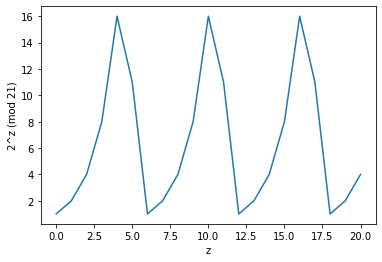

In [5]:
z = list(range(N))
y = [a**z0 % N for z0 in z]

mpl.plot(z,y)
mpl.xlabel('z')
mpl.ylabel(f'{a}^z (mod {N})')
mpl.show()

From the above graph we can see that the period r is 6 and we can also calculate it as below.

In [6]:
r = z[y[1:].index(1)+1]
print(r)

6


After we get the period r we check if it is an even number 

In [7]:
if r % 2 == 0:
    x = (a**(r/2.)) % N
    print(f'x: {x}')
    if((x+1) % N) != 0:
        print(math.gcd((int(x)+1),N), math.gcd((int(x)-1),N))
    else:
        print('x+1 is 0 (mod N)')
else:
    print('r is odd')

x: 8.0
3 7


#### **Quantum Algorithm**

In [8]:
from qiskit import *
from qiskit.algorithms import Shor

The easiest way it is implemented is shown below.

In [9]:
q_instance = Aer.get_backend('qasm_simulator')
shor = Shor(quantum_instance = q_instance)

result = shor.factor(N = 15, a = 7)
print('Prime Factors:', result.factors)

Prime Factors: [[3, 5]]


**Documentation**

In [10]:
help(shor)

Help on Shor in module qiskit.algorithms.factorizers.shor object:

class Shor(builtins.object)
 |  Shor(quantum_instance: Union[qiskit.providers.backend.Backend, qiskit.utils.quantum_instance.QuantumInstance, NoneType] = None) -> None
 |  
 |  Shor's factoring algorithm.
 |  
 |  Shor's Factoring algorithm is one of the most well-known quantum algorithms and finds the
 |  prime factors for input integer :math:`N` in polynomial time.
 |  
 |  Adapted from https://github.com/ttlion/ShorAlgQiskit
 |  
 |  See also https://arxiv.org/abs/quant-ph/0205095
 |  
 |  Methods defined here:
 |  
 |  __init__(self, quantum_instance: Union[qiskit.providers.backend.Backend, qiskit.utils.quantum_instance.QuantumInstance, NoneType] = None) -> None
 |      Args:
 |          quantum_instance: Quantum Instance or Backend
 |  
 |  construct_circuit(self, N: int, a: int = 2, measurement: bool = False) -> qiskit.circuit.quantumcircuit.QuantumCircuit
 |      Construct quantum part of the algorithm.
 |      


**Manual Implementation of the Circuits**

From Qiskit

In [11]:
from qiskit import *
import numpy as np
from qiskit.tools.visualization import plot_histogram

In [12]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [13]:
n_count = 8
a = 7

In [14]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit,n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)),m,j)
        qc.h(j)
    qc.name = "QFT Dagger"
    return qc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  import sys


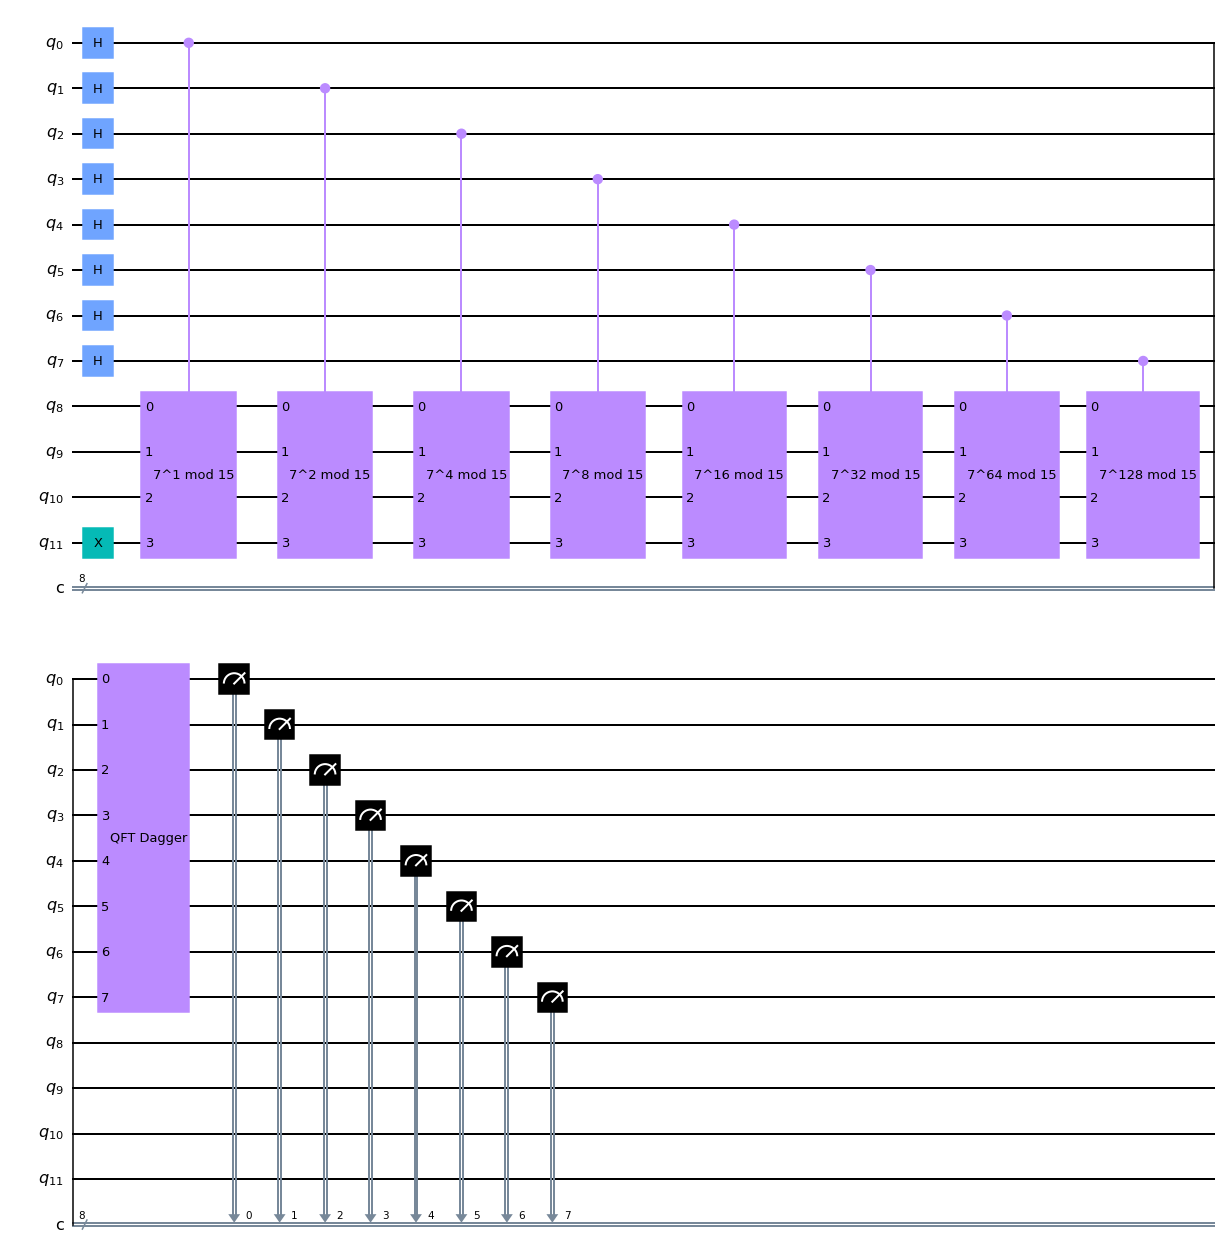

In [15]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))

qc.draw(output='mpl')

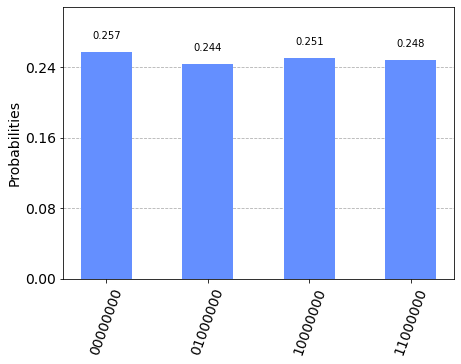

In [16]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc,backend,shots=1024).result()
counts = results.get_counts()
plot_histogram([counts])

In [17]:
# r = 4 => a^r/2 -1 = 7^2 - 1 = 48 (gcd(15,48) = 3)
# r = 4 => a^r/2 + 1 = 7^2 + 1 = 50 (gcd (15,50) = 5)

Finally, an implementation for the exponential calculator is shown below.

In [18]:
for num in range(15):
    result = np.exp(-1j*3*np.pi/8*num) + np.exp(-1j*7*np.pi/8*num) + np.exp(-1j*11*np.pi/8*num) + np.exp(-1j*15*np.pi/8*num)
    if abs(result) < 1e-10:
        result = 0
    print(num, result)

0 (4+0j)
1 0
2 0
3 0
4 (-5.757077917265737e-15+4j)
5 0
6 0
7 0
8 (-4-1.1514155834531474e-14j)
9 0
10 0
11 0
12 (2.2600304269997962e-14-4j)
13 0
14 0
